## Stage 1: Use Preprocessed Data from Part 1

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('insurance.csv')
df_encoded = df.copy()
le_sex = LabelEncoder()
df_encoded['sex'] = le_sex.fit_transform(df_encoded['sex'])
le_smoker = LabelEncoder()
df_encoded['smoker'] = le_smoker.fit_transform(df_encoded['smoker'])
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']
print(f"Dataset loaded and preprocessed")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Dataset loaded and preprocessed
Features shape: (1338, 8)
Target shape: (1338,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples (80%)")
print(f"Testing set size: {X_test.shape[0]} samples (20%)")

Training set size: 1070 samples (80%)
Testing set size: 268 samples (20%)


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()
print("Feature scaling applied using StandardScaler")
print("Target scaling applied for better SVR performance")

Feature scaling applied using StandardScaler
Target scaling applied for better SVR performance


### Get Best Polynomial Regression Results from Part 1

In [21]:
degrees = [1, 2, 3, 4, 5]
poly_results = []
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_scaled)
    X_test_poly = poly_features.transform(X_test_scaled)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    poly_results.append({
        'Degree': degree,
        'MSE': mse,
        'RMSE': rmse,
        'R2_Score': r2
    })
best_poly = max(poly_results, key=lambda x: x['R2_Score'])
print(f"Best Polynomial Regression (Degree {best_poly['Degree']}):")
print(f"  MSE:  {best_poly['MSE']:,.2f}")
print(f"  RMSE: {best_poly['RMSE']:,.2f}")
print(f"  R²:   {best_poly['R2_Score']:.4f}")

Best Polynomial Regression (Degree 2):
  MSE:  20,712,805.99
  RMSE: 4,551.13
  R²:   0.8666


## Stage 2: Train SVR Models (3 Kernels)

In [22]:
svr_models = {
    'Linear': SVR(kernel='linear', C=1.0),
    'Polynomial': SVR(kernel='poly', degree=3, C=1.0),
    'RBF': SVR(kernel='rbf', C=1.0, gamma='scale')
}
print("SVR Models to Train:")
for name, model in svr_models.items():
    print(f"  - {name} Kernel: {model}")

SVR Models to Train:
  - Linear Kernel: SVR(kernel='linear')
  - Polynomial Kernel: SVR(kernel='poly')
  - RBF Kernel: SVR()


In [23]:
svr_results = []
for name, model in svr_models.items():
    print(f"\nTraining SVR with {name} kernel...")
    model.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    svr_results.append({
        'Kernel': name,
        'MSE': mse,
        'RMSE': rmse,
        'R2_Score': r2,
        'Model': model
    })
    print(f"  MSE:  {mse:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  R²:   {r2:.4f}")


Training SVR with Linear kernel...
  MSE:  40,047,735.47
  RMSE: 6,328.33
  R²:   0.7420

Training SVR with Polynomial kernel...
  MSE:  22,659,803.12
  RMSE: 4,760.23
  R²:   0.8540

Training SVR with RBF kernel...
  MSE:  21,380,312.05
  RMSE: 4,623.88
  R²:   0.8623


## Stage 3: Evaluation for Each Kernel

In [24]:
svr_results_df = pd.DataFrame([{
    'Kernel': r['Kernel'],
    'MSE': r['MSE'],
    'RMSE': r['RMSE'],
    'R² Score': r['R2_Score']
} for r in svr_results])
print("SVR Results Summary:")
svr_results_df

SVR Results Summary:


,Kernel,MSE,RMSE,R² Score
0,Linear,4.004774e+07,6328.328015,0.742041
1,Polynomial,2.265980e+07,4760.231414,0.854042
2,RBF,2.138031e+07,4623.884952,0.862283


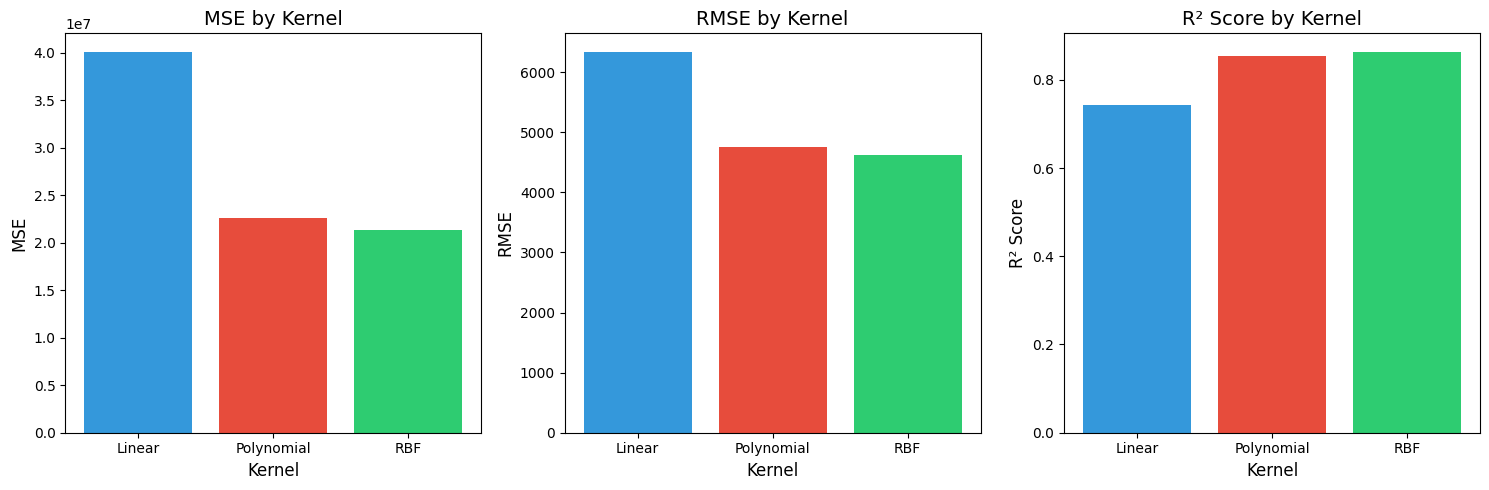

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
kernels = svr_results_df['Kernel'].tolist()
colors = ['#3498db', '#e74c3c', '#2ecc71']

axes[0].bar(kernels, svr_results_df['MSE'], color=colors)
axes[0].set_xlabel('Kernel', fontsize=12)
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_title('MSE by Kernel', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)

axes[1].bar(kernels, svr_results_df['RMSE'], color=colors)
axes[1].set_xlabel('Kernel', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE by Kernel', fontsize=14)
axes[1].tick_params(axis='x', rotation=0)

axes[2].bar(kernels, svr_results_df['R² Score'], color=colors)
axes[2].set_xlabel('Kernel', fontsize=12)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score by Kernel', fontsize=14)
axes[2].tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

## Stage 4: Analysis

In [26]:
best_svr_idx = svr_results_df['R² Score'].idxmax()
best_svr = svr_results_df.loc[best_svr_idx]

print("ANALYSIS: SVR Kernel Comparison")
print(f"""
Best Performing Kernel: {best_svr['Kernel']}
  - MSE:  {best_svr['MSE']:,.2f}
  - RMSE: {best_svr['RMSE']:,.2f}
  - R²:   {best_svr['R² Score']:.4f}
""")

ANALYSIS: SVR Kernel Comparison

Best Performing Kernel: RBF
  - MSE:  21,380,312.05
  - RMSE: 4,623.88
  - R²:   0.8623



In [27]:
print("DISCUSSION: Effect of Kernel Choice")

print("""
1. LINEAR KERNEL:
   - Creates a linear decision boundary
   - Works well when data is linearly separable
   - Fastest to train and predict
   - May underfit if relationships are non-linear

2. POLYNOMIAL KERNEL:
   - Creates polynomial decision boundaries
   - Can capture non-linear relationships
   - Higher degree = more complex boundaries
   - Risk of overfitting with high degrees

3. RBF (Radial Basis Function) KERNEL:
   - Creates complex, non-linear decision boundaries
   - Most flexible kernel
   - Can handle complex patterns in data
   - Good default choice for many problems
   - May overfit if not properly tuned
""")

DISCUSSION: Effect of Kernel Choice

1. LINEAR KERNEL:
   - Creates a linear decision boundary
   - Works well when data is linearly separable
   - Fastest to train and predict
   - May underfit if relationships are non-linear

2. POLYNOMIAL KERNEL:
   - Creates polynomial decision boundaries
   - Can capture non-linear relationships
   - Higher degree = more complex boundaries
   - Risk of overfitting with high degrees

3. RBF (Radial Basis Function) KERNEL:
   - Creates complex, non-linear decision boundaries
   - Most flexible kernel
   - Can handle complex patterns in data
   - Good default choice for many problems
   - May overfit if not properly tuned



In [28]:
print(f"WHY {best_svr['Kernel'].upper()} KERNEL PERFORMS BEST")

if best_svr['Kernel'] == 'RBF':
    print("""
The RBF kernel performs best because:

1. Flexibility: RBF can model complex, non-linear relationships between
   features and insurance charges.

2. Local Influence: Each data point has a local influence, which helps
   capture the varying patterns in different regions of the feature space.

3. Automatic Complexity: The 'gamma' parameter controls the influence of
   each training example, allowing the model to adapt to data complexity.

4. Medical Data Nature: Insurance charges depend on complex interactions
   between age, BMI, smoking status, etc. - RBF captures these interactions.
""")
elif best_svr['Kernel'] == 'Linear':
    print("""
The Linear kernel performs best because:

1. Simplicity: The relationship between features and charges is relatively
   linear after preprocessing.

2. Generalization: Linear models generalize better and avoid overfitting.

3. Feature Engineering: The encoded categorical features already capture
   important non-linear effects (like smoking status impact).
""")
else: 
    print("""
The Polynomial kernel performs best because:

1. Moderate Complexity: The data has polynomial relationships that this
   kernel can capture effectively.

2. Balance: Polynomial kernel provides a good balance between linear
   (too simple) and RBF (potentially overfitting).

3. Feature Interactions: The polynomial kernel naturally models interactions
   between features like age×bmi, age×smoker, etc.
""")

WHY RBF KERNEL PERFORMS BEST

The RBF kernel performs best because:

1. Flexibility: RBF can model complex, non-linear relationships between
   features and insurance charges.

2. Local Influence: Each data point has a local influence, which helps
   capture the varying patterns in different regions of the feature space.

3. Automatic Complexity: The 'gamma' parameter controls the influence of
   each training example, allowing the model to adapt to data complexity.

4. Medical Data Nature: Insurance charges depend on complex interactions
   between age, BMI, smoking status, etc. - RBF captures these interactions.



## Stage 5: Final Comparison Table

In [29]:
comparison_data = [
    {
        'Model': f"Polynomial Regression (degree={best_poly['Degree']})",
        'MSE': best_poly['MSE'],
        'RMSE': best_poly['RMSE'],
        'R² Score': best_poly['R2_Score']
    }
]
for result in svr_results:
    comparison_data.append({
        'Model': f"SVR ({result['Kernel']})",
        'MSE': result['MSE'],
        'RMSE': result['RMSE'],
        'R² Score': result['R2_Score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("FINAL COMPARISON TABLE")
print()
comparison_df

FINAL COMPARISON TABLE



,Model,MSE,RMSE,R² Score
0,Polynomial Regression (degree=2),2.071281e+07,4551.132385,0.866583
1,SVR (Linear),4.004774e+07,6328.328015,0.742041
2,SVR (Polynomial),2.265980e+07,4760.231414,0.854042
3,SVR (RBF),2.138031e+07,4623.884952,0.862283


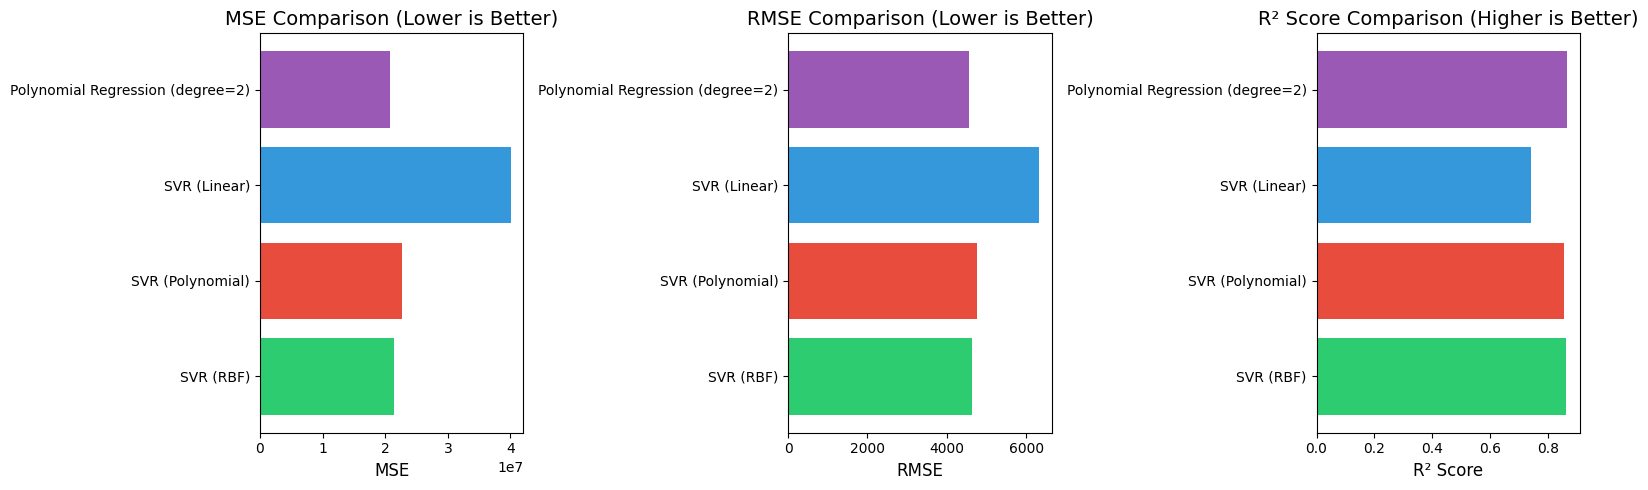

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
models = comparison_df['Model'].tolist()
colors = ['#9b59b6', '#3498db', '#e74c3c', '#2ecc71']

axes[0].barh(models, comparison_df['MSE'], color=colors)
axes[0].set_xlabel('MSE', fontsize=12)
axes[0].set_title('MSE Comparison (Lower is Better)', fontsize=14)
axes[0].invert_yaxis()

axes[1].barh(models, comparison_df['RMSE'], color=colors)
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('RMSE Comparison (Lower is Better)', fontsize=14)
axes[1].invert_yaxis()

axes[2].barh(models, comparison_df['R² Score'], color=colors)
axes[2].set_xlabel('R² Score', fontsize=12)
axes[2].set_title('R² Score Comparison (Higher is Better)', fontsize=14)
axes[2].invert_yaxis()
plt.tight_layout()
plt.show()

In [31]:
best_model_idx = comparison_df['R² Score'].idxmax()
best_model = comparison_df.loc[best_model_idx]
print("OVERALL BEST MODEL")
print(f"""
Best Performing Model: {best_model['Model']}
  - MSE:  {best_model['MSE']:,.2f}
  - RMSE: {best_model['RMSE']:,.2f}
  - R²:   {best_model['R² Score']:.4f}
""")

OVERALL BEST MODEL

Best Performing Model: Polynomial Regression (degree=2)
  - MSE:  20,712,805.99
  - RMSE: 4,551.13
  - R²:   0.8666



## Summary

In [ ]:
print("SVR ANALYSIS SUMMARY")

print(f"""
Dataset: Medical Cost Personal Dataset (Insurance)
Target Variable: charges (Medical insurance cost)
Training Samples: {X_train.shape[0]}
Testing Samples: {X_test.shape[0]}

SVR Models Trained:
  1. Linear Kernel
  2. Polynomial Kernel (degree=3)
  3. RBF Kernel

Best SVR Kernel: {best_svr['Kernel']}
Best SVR R² Score: {best_svr['R² Score']:.4f}

Overall Best Model: {best_model['Model']}
Overall Best R² Score: {best_model['R² Score']:.4f}
""")

print("\nFull Comparison Table:")
comparison_df

SVR ANALYSIS SUMMARY

Dataset: Medical Cost Personal Dataset (Insurance)
Target Variable: charges (Medical insurance cost)
Training Samples: 1070
Testing Samples: 268

SVR Models Trained:
  1. Linear Kernel
  2. Polynomial Kernel (degree=3)
  3. RBF Kernel

Best SVR Kernel: RBF
Best SVR R² Score: 0.8623

Overall Best Model: Polynomial Regression (degree=2)
Overall Best R² Score: 0.8666


Full Comparison Table:


,Model,MSE,RMSE,R² Score
0,Polynomial Regression (degree=2),2.071281e+07,4551.132385,0.866583
1,SVR (Linear),4.004774e+07,6328.328015,0.742041
2,SVR (Polynomial),2.265980e+07,4760.231414,0.854042
3,SVR (RBF),2.138031e+07,4623.884952,0.862283
